In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [12]:
# CONFIG
FEATURE_DIM = 200  # 100 MFCC + 100 eGeMAPS
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
NUM_CLASSES = 2   # or 2 if binary classification
# DATA_DIR = r"/content/drive/MyDrive/CGS616_project_data/Audio_model(all Audio related files)/BoAW_combined_no_timestamp(train-test data)" #access concatenated datasets
# LABEL_FILE = r"/content/drive/MyDrive/CGS616_project_data/final_merged_labels.csv"
DATA_DIR = r"C:\Users\ASUS\Downloads\BoAW_combined-20250427T130943Z-001\BoAW_combined" #access concatenated datasets
LABEL_FILE = r"C:\Users\ASUS\Downloads\Dep.csv"

In [3]:
MAX_TIMESTEPS = 10000

In [14]:
# Load labels
label_df = pd.read_csv(LABEL_FILE)
label_map = {str(row['Participant']): row['Depression_label'] for _, row in label_df.iterrows()}

In [15]:
class SleepDataset(Dataset):
    def __init__(self, file_paths, label_map, max_len):
        self.paths = sorted(file_paths)  # Already a list, no need for os.listdir
        self.label_map = label_map
        self.max_len = max_len

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        df = pd.read_csv(self.paths[idx])
        data = df.iloc[:, 0:].values  # Skip timestamp column
        data = data[:self.max_len]
        if len(data) < self.max_len:
            pad_width = self.max_len - len(data)
            data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
        data = StandardScaler().fit_transform(data)

        label_name = os.path.basename(self.paths[idx]).split('_')[0]  # Example: "0_participant1.csv"
        label = self.label_map[label_name]
        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [16]:
import torch.nn as nn
import torch

import torch

class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        # 1D CNN to compress features
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )

        # BiLSTM to capture temporal patterns
        self.lstm = nn.LSTM(128, 128, batch_first=True, bidirectional=True, dropout=0.3)

        # Self-Attention Layer
        self.attention = nn.Linear(256, 1)  # Learn attention scores per timestep

        self.norm = nn.LayerNorm(256)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]

        x = x.transpose(1, 2)             # [batch, input_dim, seq_len] for CNN
        x = self.cnn(x)                   # [batch, 128, seq_len]

        x = x.transpose(1, 2)              # [batch, seq_len, 128] for LSTM
        x, _ = self.lstm(x)                # [batch, seq_len, 256]

        # ---- Attention ----
        attn_weights = torch.softmax(self.attention(x), dim=1)  # [batch, seq_len, 1]
        x = (x * attn_weights).sum(dim=1)                       # Weighted sum → [batch, 256]

        x = self.norm(x)
        x = torch.relu(self.fc1(x))        # [batch, 64]
        x = self.dropout(x)
        return self.fc2(x)                 # [batch, output_dim]


In [17]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [18]:
test_participant_ids = {
    "600", "602", "604", "605", "606", "607", "609", "615", "618", "619", "620", "622", "623", "624",
    "625", "626", "629", "631", "634", "635", "636", "637", "638", "640", "649", "650", "651", "652",
    "655", "656", "658", "659", "661", "663", "664", "666", "669", "676", "679", "682", "683", "688",
    "689", "691", "693", "696", "699", "705", "708", "709", "710", "712", "715", "716", "717", "718"
}


def split_dataset_by_participant_id(data_dir, test_ids):
    all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv")]
    test_files = [f for f in all_files if os.path.basename(f).split('_')[0] in test_ids]
    train_dev_files = [f for f in all_files if os.path.basename(f).split('_')[0] not in test_ids]
    return train_dev_files, test_files

In [19]:
train_label_map = {k: v for k, v in label_map.items() if k not in test_participant_ids}
train_label_df = pd.DataFrame(list(train_label_map.items()), columns=['ID', 'Depression_label'])
train_label_df

,ID,Depression_label
0,300,0
1,301,0
2,302,0
3,303,0
4,304,0
...,...,...
214,698,1
215,702,0
216,703,0
217,707,0


In [22]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from collections import Counter

def train_and_evaluate():
    train_dev_files, test_files = split_dataset_by_participant_id(DATA_DIR, test_participant_ids)
    full_train_dev_set = SleepDataset(train_dev_files, label_map, max_len=8000)
    test_set = SleepDataset(test_files, label_map, max_len=8000)

    train_size = int(0.8 * len(full_train_dev_set))
    val_size = len(full_train_dev_set) - train_size
    train_set, val_set = random_split(full_train_dev_set, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

    model = CNN_BiLSTM_Attention(FEATURE_DIM, NUM_CLASSES).to(device)


    # Suppose your labels are loaded properly
    label_counts = Counter(train_label_df['Depression_label'])  # Only use the labels column
    # Now compute inverse class weights
    total = sum(label_counts.values())
    class_weights = [total / label_counts[i] for i in range(len(label_counts))]
    weights = torch.tensor(class_weights).to(device)

    #define the loss
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    early_stopper = EarlyStopping(patience=15, min_delta=0.001)

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_model_state = None
    best_val_acc = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        train_losses.append(total_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item()
                all_preds.extend(preds.argmax(dim=1).cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)


        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
              f"Train Loss: {total_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        early_stopper(1 - val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = deepcopy(model.state_dict())

        if early_stopper.early_stop:
            print("⏹️ Early stopping triggered.")
            break

    # Load best model
    model.load_state_dict(best_model_state)
    model.eval()

    # 🧪 Final Test Predictions + Probabilities
    test_preds, test_labels = [], []
    audio_prob_0_list, audio_prob_1_list = [], []
    true_label_list, predicted_label_list = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            probs = torch.softmax(model(xb), dim=1)  # Get probabilities
            preds = probs.argmax(dim=1)

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(yb.cpu().numpy())

            audio_prob_0_list.extend(probs[:, 0].cpu().numpy())
            audio_prob_1_list.extend(probs[:, 1].cpu().numpy())
            true_label_list.extend(yb.cpu().numpy())
            predicted_label_list.extend(preds.cpu().numpy())


    final_test_acc = accuracy_score(test_labels, test_preds)
    print(f"✅ Final Test Accuracy: {final_test_acc:.4f}")

    # ✅ Save to Excel
    df_probs = pd.DataFrame({
        "audio_prob_0": audio_prob_0_list,
        "audio_prob_1": audio_prob_1_list,
        "true_label": true_label_list,
        "predicted_label": predicted_label_list
    })

    df_probs.to_excel("audio_test_predictions.xlsx", index=False)
    print("📁 Saved audio prediction probabilities to 'audio_test_predictions.xlsx'")

    # 📊 Plots
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color='red')
    plt.plot(epochs, val_losses, label="Val Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs, train_accuracies, label="Train Acc", color='blue')
    plt.plot(epochs, val_accuracies, label="Val Acc", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    cm = confusion_matrix(test_labels, test_preds)
    plt.subplot(1, 4, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    report = classification_report(test_labels, test_preds, digits=4, output_dict=True)
    f1_scores = [report[str(i)]['f1-score'] for i in range(NUM_CLASSES)]
    plt.subplot(1, 4, 4)
    plt.bar(range(NUM_CLASSES), f1_scores, color='purple')
    plt.title("F1-Score per Class")
    plt.xlabel("Class")
    plt.ylabel("F1 Score")
    plt.tight_layout()
    plt.show()

    print("Classification Report:\n")
    print(classification_report(test_labels, test_preds, digits=4))

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/20 | Train Loss: 4.2977, Acc: 0.6171 | Val Loss: 1.4139, Acc: 0.6136
Epoch 2/20 | Train Loss: 3.9979, Acc: 0.6171 | Val Loss: 1.4563, Acc: 0.6818
Epoch 3/20 | Train Loss: 3.9171, Acc: 0.6400 | Val Loss: 1.5289, Acc: 0.7045
Epoch 4/20 | Train Loss: 3.7763, Acc: 0.6857 | Val Loss: 1.5076, Acc: 0.6818
Epoch 5/20 | Train Loss: 3.5781, Acc: 0.7086 | Val Loss: 1.4450, Acc: 0.6591
Epoch 6/20 | Train Loss: 3.4106, Acc: 0.7257 | Val Loss: 1.5033, Acc: 0.6818
Epoch 7/20 | Train Loss: 3.3482, Acc: 0.7486 | Val Loss: 1.5023, Acc: 0.6818
Epoch 8/20 | Train Loss: 3.3511, Acc: 0.7829 | Val Loss: 1.4343, Acc: 0.6591
Epoch 9/20 | Train Loss: 3.1580, Acc: 0.7829 | Val Loss: 1.3726, Acc: 0.6818
Epoch 10/20 | Train Loss: 2.9150, Acc: 0.8514 | Val Loss: 1.3178, Acc: 0.7273
Epoch 11/20 | Train Loss: 2.9234, Acc: 0.8629 | Val Loss: 1.3071, Acc: 0.7273
Epoch 12/20 | Train Loss: 2.7447, Acc: 0.8686 | Val Loss: 1.3675, Acc: 0.7045
Epoch 13/20 | Train Loss: 2.5196, Acc: 0.8743 | Val Loss: 1.3934, Acc: 0.

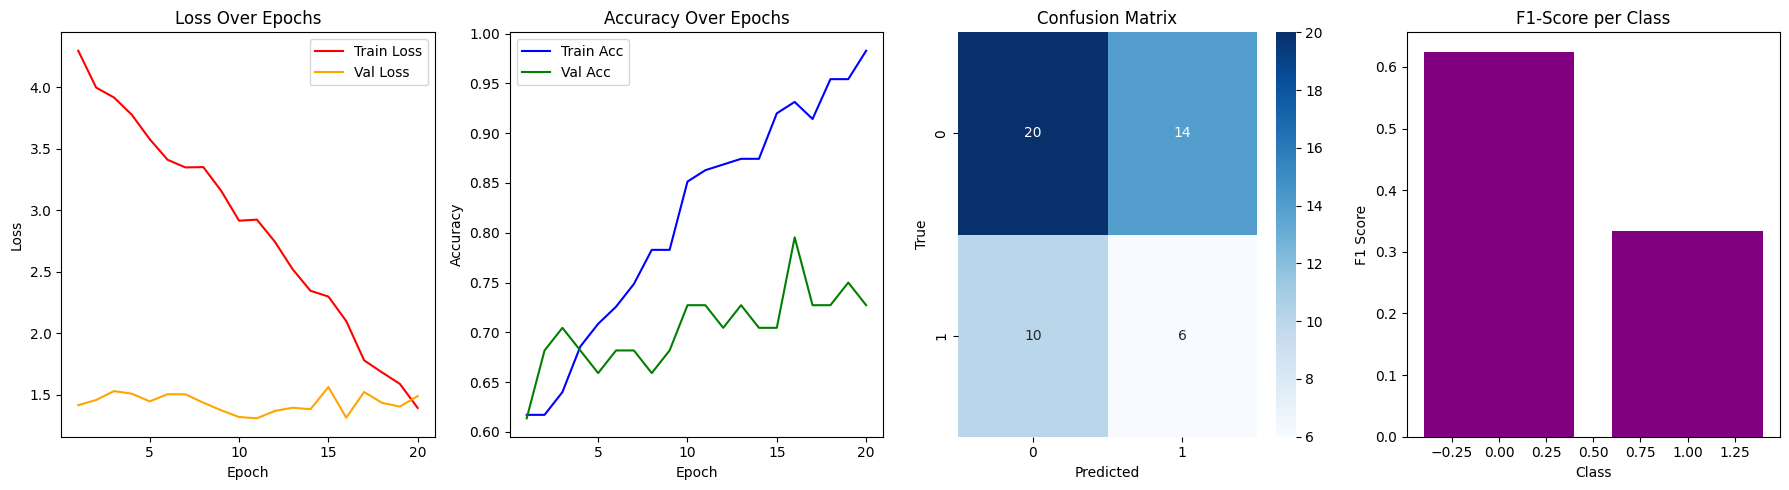

Classification Report:

              precision    recall  f1-score   support

           0     0.6667    0.5882    0.6250        34
           1     0.3000    0.3750    0.3333        16

    accuracy                         0.5200        50
   macro avg     0.4833    0.4816    0.4792        50
weighted avg     0.5493    0.5200    0.5317        50



In [23]:
# Run the training
if __name__ == "__main__":
    train_and_evaluate()